# Forecasting

# Importing Libraries and Dataset

In [ ]:
import pandas as pd
# import plotly.express as px
# import plotly.graph_objects as go
# from ydata_profiling import ProfileReport
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from collections import defaultdict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import random
import xgboost as xgb
from prophet import Prophet

In [ ]:
df = pd.read_csv('../../Stationary/Data/walmart.csv')

In [ ]:
def cleaning(df_copy: pd.DataFrame) -> pd.DataFrame:
    df = df_copy.copy(deep=True)
    df['Date'] = pd.to_datetime(df['Date'], format=r"%d-%m-%Y")
    df['Store'] = df['Store'].astype(pd.StringDtype()).astype('category')
    df['Holiday_Flag'] = df['Holiday_Flag'].astype(pd.BooleanDtype())
    df = df.rename(columns={col: col.lower() for col in df.columns})
    return df

df = cleaning(df)

## ToDo
1. Use Darts libary's anamoly detector + forecaster to incorporate actual 'holidays' events that boost sales in forecasting.
2. Analysze residuals. Check the Ljung-Box test for residuals.
3. Add another loss metric too?
4. Use SHAP to analyse models post training.
5. Create results_dict as json convertible object and save it to a file.

### Different models

1. Holt Winters i.e. Triple Exponential Smoothing 

2. ARIMA with orders
    - (6, 1, 4)
    - (6, 1, 5)
    - (6, 2, 4)
    - (6, 2, 5)
    - (9, 2, 4)
    - (9, 2, 5)

3. SARIMA with orders
    - (6, 1, 4), (2, 1, 5, 52)
    - (6, 1, 5), (2, 1, 5, 52)
    - (6, 2, 4), (2, 1, 5, 52)
    - (6, 2, 5), (2, 1, 5, 52)
    - (9, 2, 4), (2, 1, 5, 52)
    - (9, 2, 5), (2, 1, 5, 52)

4. SARIMAX with cpi, holiday_flag and orders
    - (6, 1, 4), (2, 1, 5, 52)
    - (6, 1, 5), (2, 1, 5, 52)
    - (6, 2, 4), (2, 1, 5, 52)
    - (6, 2, 5), (2, 1, 5, 52)
    - (9, 2, 4), (2, 1, 5, 52)
    - (9, 2, 5), (2, 1, 5, 52)

5. XGBoost with
    - month
    - year
    - holiday_flag
    - CPI
    - lagged sales

6. FB Prophet

## Train, Test and Eval split

In [ ]:
# Get sorted unique dates
unique_dates = sorted(df['date'].unique())
total_weeks = len(unique_dates)

# Reserve final 12 weeks for hold-out (final forecast)
holdout_dates = unique_dates[-12:]

# The remaining weeks (training + validation): should be total_weeks - 12.
train_val_dates = unique_dates[:-12]

# Split the 131 weeks: the first 105 weeks for training and the next 26 weeks for validation
train_dates = train_val_dates[:105]
val_dates = train_val_dates[105:]

## Loss metric

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


## Data Preparation

In [ ]:
# Get the unique store identifiers (assuming 'store' is categorical)
stores = df['store'].cat.categories.tolist()

# Create a results dictionary to store individual store results, and later aggregated metrics
results_dict = {}
results_dict['HoltWinters'] = {"store_results": {}, "aggregated_metrics": {}}

# We will forecast in 2-week horizons over the 26 validation weeks.
forecast_horizon = 1
n_forecast_iterations = len(val_dates) // forecast_horizon  # should be 26/2 = 13

## Model Training

### Holt Winters 

#### Training

In [ ]:


# Loop over each store
for store in stores:
    # Filter the store’s data and sort it by date.
    store_df = df[df['store'] == store].sort_values('date').reset_index(drop=True)
    
    # Split the store data into training and validation sets based on date.
    train_store_df = store_df[store_df['date'].isin(train_dates)]
    valid_store_df = store_df[store_df['date'].isin(val_dates)]
    
    # Extract the weekly sales series (using 'date' as index)
    train_series = train_store_df.set_index('date')['weekly_sales']
    
    # Initialize lists to collect forecasts and actual values as we do a growing-window forecast.
    store_predictions = []
    store_actuals = []
    forecast_dates_list = []
    
    # Start with the training series; as we move forward, this will grow.
    series_gw = train_series.copy()
    
    # Iterate over each 2-week forecast window
    for i in range(n_forecast_iterations):
        # Fit the Holt–Winters (triple exponential smoothing) model:
        # We assume an additive trend and additive seasonal component with season_length 52.
        model = ExponentialSmoothing(
            series_gw,
            trend="add",
            seasonal="add",
            seasonal_periods=52,
            initialization_method="estimated",
            # use_boxcox=True
        )

        with warnings.filterwarnings("ignore"):
            fit = model.fit(optimized=True, remove_bias=True, use_brute=True)
            
            # Forecast the next 'forecast_horizon' weeks
            forecast = fit.forecast(forecast_horizon)
        
        # Determine the forecast dates from our validation dates.
        # For each iteration, select the next 2 weeks in order.
        fc_start = i * forecast_horizon
        fc_end = (i + 1) * forecast_horizon
        fc_dates = val_dates[fc_start:fc_end]
        
        # Get the actual weekly sales for the forecast dates from the validation set.
        valid_series = valid_store_df.set_index('date')['weekly_sales']
        actual = valid_series.loc[fc_dates]
        
        # Append these forecasts and actuals to our lists.
        store_predictions.extend(forecast.values)
        store_actuals.extend(actual.values)
        forecast_dates_list.extend(fc_dates)
        
        # Update the growing window: as if we received these observations.
        # (Using pd.concat instead of .append to avoid deprecation warnings.)
        series_gw = pd.concat([series_gw, actual]).sort_index()
    
    # After finishing the growing window forecast, compute rmse for the store.
    store_predictions = np.array(store_predictions)
    store_actuals = np.array(store_actuals)
    store_rmse = rmse(store_actuals, store_predictions)
    
    # Save results for this store.
    results_dict['HoltWinters']['store_results'][store] = {
        'forecast_dates': forecast_dates_list,
        'predictions': store_predictions,
        'actuals': store_actuals,
        'rmse': store_rmse
    }

c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:47

#### Calculate Errors

In [ ]:
all_rmse = []
for store in stores:
    store_rmse = results_dict['HoltWinters']['store_results'][store]['rmse']
    all_rmse.append(store_rmse)

avg_rmse = np.mean(all_rmse)
std_rmse = np.std(all_rmse)

results_dict['HoltWinters']['aggregated_metrics'] = {
    'avg_rmse': avg_rmse,
    'std_rmse': std_rmse
}

print("Holt Winters Aggregated RMSE across stores:")
print("Average RMSE:", avg_rmse)
print("Std of RMSE:", std_rmse)

Holt Winters Aggregated RMSE across stores:
Average RMSE: 58874.64921348473
Std of RMSE: 38530.58176058082


#### Visualize predictions

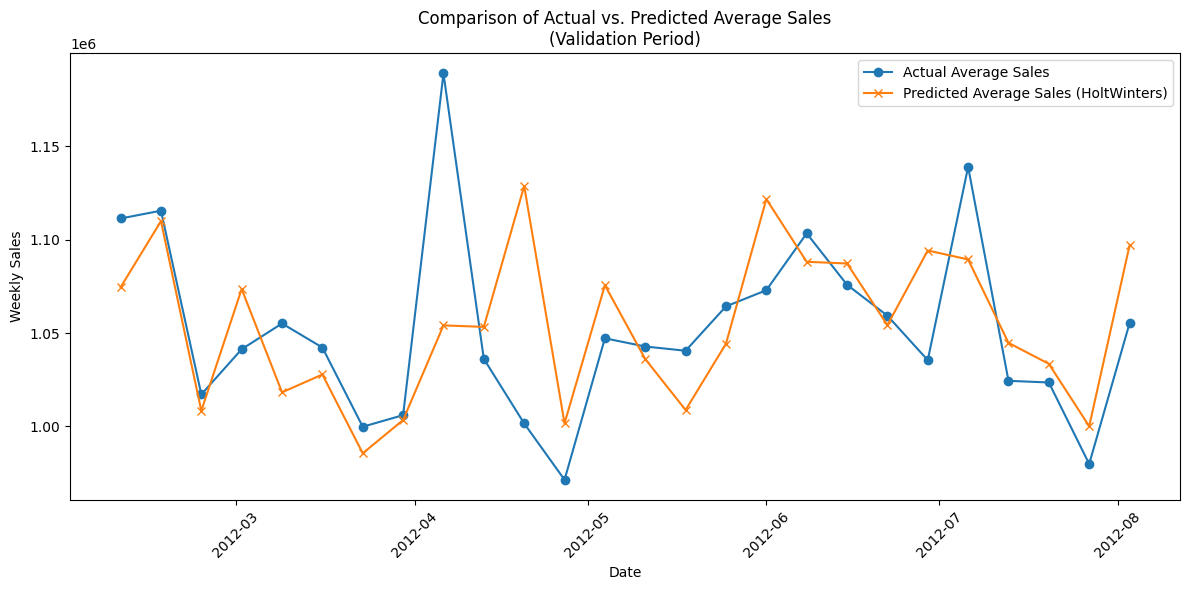

In [ ]:
# Initialize dictionaries to aggregate forecast values by date.
pred_by_date = defaultdict(list)
actual_by_date = defaultdict(list)

# Loop through each store's results
for store in stores:
    store_result = results_dict['HoltWinters']['store_results'][store]
    for dt, pred, actual in zip(store_result['forecast_dates'],
                                  store_result['predictions'],
                                  store_result['actuals']):
        # Convert dt into a pd.Timestamp (if not already)
        dt = pd.to_datetime(dt)
        pred_by_date[dt].append(pred)
        actual_by_date[dt].append(actual)

# Sort the forecasted dates
sorted_dates = sorted(pred_by_date.keys())

# For each date, compute the average predicted and actual weekly sales.
avg_pred = [np.mean(pred_by_date[dt]) for dt in sorted_dates]
avg_actual = [np.mean(actual_by_date[dt]) for dt in sorted_dates]

# Plot the actual vs. predicted average sales
plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, avg_actual, marker='o', label='Actual Average Sales')
plt.plot(sorted_dates, avg_pred, marker='x',
         label='Predicted Average Sales (HoltWinters)')
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("Comparison of Actual vs. Predicted Average Sales\n(Validation Period)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### ARIMA

#### Training

In [ ]:
# Define candidate ARIMA orders to consider
candidate_orders = [(6, 1, 4), (6, 1, 5), (6, 2, 4), (6, 2, 5)]

# Initialize space in results_dict for ARIMA results
results_dict['ARIMA'] = {"store_results": {}, "aggregated_metrics": {}}

# Get unique stores (assuming the store column is categorical)
stores = df['store'].cat.categories.tolist()

# Loop over each store
for store in stores:
    # Filter the store’s data and sort by date
    store_df = df[df['store'] == store].sort_values('date').reset_index(drop=True)
    
    # Split the data into training and validation based on date.
    train_store_df = store_df[store_df['date'].isin(train_dates)]
    valid_store_df = store_df[store_df['date'].isin(val_dates)]
    
    # Extract the weekly sales series from training data.
    train_series = train_store_df.set_index('date')['weekly_sales']
    
    # First, determine the best ARIMA order by fitting each candidate on just the
    # training portion (105 weeks) and comparing their AIC.
    best_aic = np.inf
    best_order = None
    aic_bic = pd.DataFrame(columns=['order', 'aic', 'bic'], index = list(range(len(candidate_orders)))) 
    for idx, order in enumerate(candidate_orders):
        try:
            # Suppress warnings during the ARIMA fitting
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = ARIMA(train_series, order=order)
                fit_model = model.fit()
                aic_bic.iloc[idx]['order'] = order
                aic_bic.iloc[idx]['aic'] = fit_model.aic
                aic_bic.iloc[idx]['bic'] = fit_model.bic
                # print(f"For store {store}, order {order}, AIC: {fit_model.aic}, BIC: {fit_model.bic}")
            if fit_model.aic < best_aic:
                best_aic = fit_model.aic
                best_order = order
        except Exception as e:
            print(f"Store {store}, order {order} failed: {e}")
            continue

    print(f"Store {store} -- Selected ARIMA order: {best_order} (AIC: {best_aic}) (BIC: {fit_model.bic})")
    
    # Now, using the selected best_order, do a growing-window forecast on the
    # 26-week validation set (forecasting 2 weeks at a time).
    store_predictions = []
    store_actuals = []
    forecast_dates_list = []
    
    # Start the growing window with the training series.
    series_gw = train_series.copy()
    
    # The number of forecast iterations (26 weeks / 2 per iteration).
    n_forecast_iterations = len(val_dates) // forecast_horizon
    
    for i in range(n_forecast_iterations):
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model_gw = ARIMA(series_gw, order=best_order)
                fit_gw = model_gw.fit()
            forecast_result = fit_gw.forecast(steps=forecast_horizon)
        except Exception as e:
            print(f"Store {store}: Forecast iteration {i} failed with error: {e}")
            # If forecasting fails, you can choose to assign missing values.
            forecast_result = np.full(forecast_horizon, np.nan)
    
        # Identify the forecast dates (next 2 weeks from the validation list)
        fc_start = i * forecast_horizon
        fc_end = (i + 1) * forecast_horizon
        fc_dates = val_dates[fc_start:fc_end]
        
        # Get the actual values for these forecast dates
        valid_series = valid_store_df.set_index('date')['weekly_sales']
        actual = valid_series.loc[fc_dates]
    
        # Append predictions, actuals, and forecast dates
        store_predictions.extend(
            forecast_result if isinstance(forecast_result, np.ndarray)
            else forecast_result.tolist()
        )
        store_actuals.extend(actual.values)
        forecast_dates_list.extend(fc_dates)
    
        # Grow the training window with the actual observations just forecasted.
        series_gw = pd.concat([series_gw, actual]).sort_index()
    
    # Compute rmse for the store based on the growing window forecasts
    store_predictions = np.array(store_predictions)
    store_actuals = np.array(store_actuals)
    store_rmse = rmse(store_actuals, store_predictions)
    
    # Save the results for this store in results_dict
    results_dict['ARIMA']['store_results'][store] = {
        'best_order': best_order,
        'forecast_dates': forecast_dates_list,
        'predictions': store_predictions,
        'actuals': store_actuals,
        'rmse': store_rmse
    }

Store 1 -- Selected ARIMA order: (6, 1, 4) (AIC: 2818.0780648587734) (BIC: 2867.8032434909373)
Store 10 -- Selected ARIMA order: (6, 2, 4) (AIC: 2936.7706540487275) (BIC: 2970.7334521002676)
Store 11 -- Selected ARIMA order: (6, 1, 5) (AIC: 2818.2951002710333) (BIC: 2859.357184555432)
Store 12 -- Selected ARIMA order: (6, 1, 4) (AIC: 2784.594169993079) (BIC: 2826.0934982129324)
Store 13 -- Selected ARIMA order: (6, 2, 4) (AIC: 2920.7060725956435) (BIC: 2955.0601067873613)
Store 14 -- Selected ARIMA order: (6, 1, 5) (AIC: 2930.240327463138) (BIC: 2970.464970007862)
Store 15 -- Selected ARIMA order: (6, 1, 4) (AIC: 2749.2833027404986) (BIC: 2782.68241567147)
Store 16 -- Selected ARIMA order: (6, 2, 4) (AIC: 2652.273495741868) (BIC: 2684.316875653312)
Store 17 -- Selected ARIMA order: (6, 1, 4) (AIC: 2740.223806509719) (BIC: 2784.680324890462)
Store 18 -- Selected ARIMA order: (6, 1, 4) (AIC: 2828.9544456785757) (BIC: 2863.708195402188)
Store 19 -- Selected ARIMA order: (6, 1, 5) (AIC: 28

#### Calculate Errors

In [ ]:
# Aggregate error metrics (across all stores)
all_rmse = []
for store in stores:
    store_rmse = results_dict['ARIMA']['store_results'][store]['rmse']
    all_rmse.append(store_rmse)
    if pd.isnull(store_rmse):
        print("Store:", store, "has no RMSE")

avg_rmse = np.mean(all_rmse, where=~np.isnan(all_rmse))
std_rmse = np.std(all_rmse, where=~np.isnan(all_rmse))

results_dict['ARIMA']['aggregated_metrics'] = {
    'avg_rmse': avg_rmse,
    'std_rmse': std_rmse
}

pd.Series(all_rmse).describe()

Store: 38 has no RMSE


count        44.000000
mean      73483.575356
std       41815.577837
min       11108.056022
25%       43897.261231
50%       65114.565923
75%      113117.467519
max      167100.140862
dtype: float64

#### Visualize Predictions

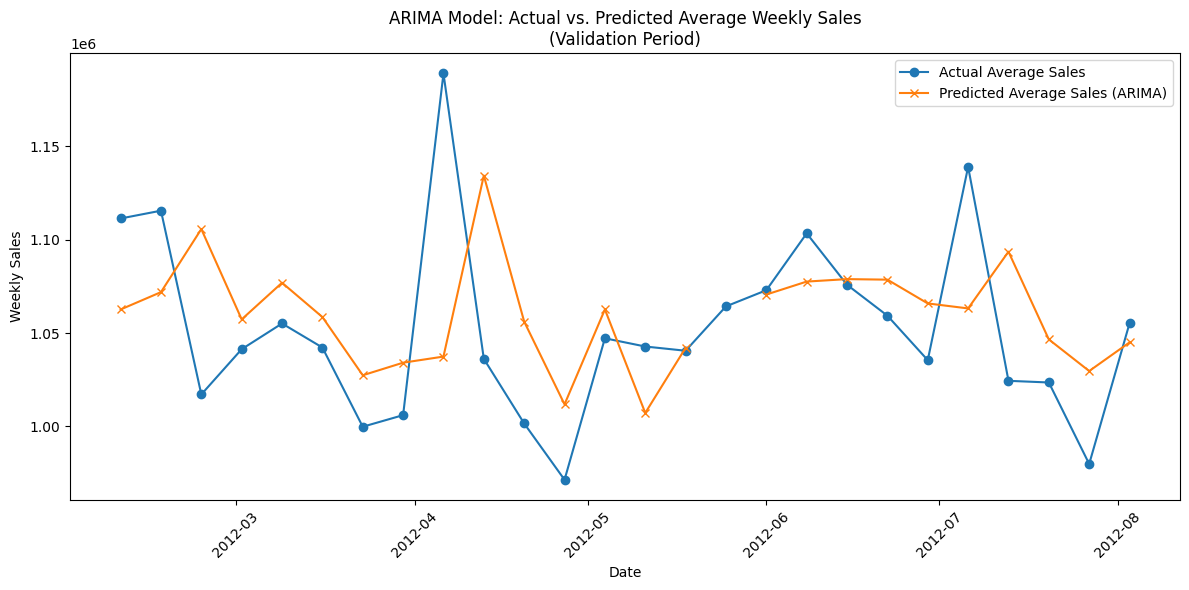

In [ ]:
# We'll collect forecasted predictions and actuals per date across all stores.
pred_by_date = defaultdict(list)
actual_by_date = defaultdict(list)

for store in stores:
    store_result = results_dict['ARIMA']['store_results'][store]
    for dt, pred, act in zip(store_result['forecast_dates'],
                             store_result['predictions'],
                             store_result['actuals']):
        dt = pd.to_datetime(dt)
        pred_by_date[dt].append(pred)
        actual_by_date[dt].append(act)

# Sort the forecasted dates
sorted_dates = sorted(pred_by_date.keys())

# Calculate the average predicted and actual sales across stores for each date.
avg_pred = [np.mean(pred_by_date[dt]) for dt in sorted_dates]
avg_actual = [np.mean(actual_by_date[dt]) for dt in sorted_dates]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, avg_actual, marker='o', label='Actual Average Sales')
plt.plot(sorted_dates, avg_pred, marker='x',
         label='Predicted Average Sales (ARIMA)')
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("ARIMA Model: Actual vs. Predicted Average Weekly Sales\n(Validation Period)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### SARIMA

#### Separate train test split and growing windows

In [ ]:
# Split the 131 weeks: the first 111 weeks for training and the next 20 weeks for validation
train_dates = train_val_dates[:105]
val_dates = train_val_dates[105:]

# We will forecast in 4-week horizons over the 20 validation weeks.
forecast_horizon = 1
n_forecast_iterations = len(val_dates) // forecast_horizon  # should be 20/2 = 10

random_stores = random.sample(stores, 25)

#### Training

In [ ]:
# Define candidate non-seasonal orders for SARIMA
candidate_orders = [(6, 1, 4)] # , (6, 1, 5), (6, 2, 4), (6, 2, 5)
# Fixed seasonal order: (P, D, Q, m)
seasonal_order = (2, 1, 5, 52)

# Initialize space in the results dictionary for SARIMA
results_dict['SARIMA'] = {"store_results": {}, "aggregated_metrics": {}}

# Loop over each store
for store in random_stores:
    # Filter the store’s data and sort by date
    store_df = df[df['store'] == store].sort_values('date').reset_index(drop=True)
    
    # Split the store data into training and validation based on date
    train_store_df = store_df[store_df['date'].isin(train_dates)]
    valid_store_df = store_df[store_df['date'].isin(val_dates)]
    
    # Convert training data into a time series with date as index
    train_series = train_store_df.set_index('date')['weekly_sales']
    
    # -----------------------------------------------------
    # Step 1: Model Selection -- Choose Best Non-Seasonal Order
    # -----------------------------------------------------
    best_aic = np.inf
    best_order = None
    # aic_bic = pd.DataFrame(columns=['order', 'aic', 'bic'], index = list(range(len(candidate_orders)))) 
    for order in candidate_orders:
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = SARIMAX(train_series,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                fit_model = model.fit(disp=False)
                # aic_bic.iloc[idx]['order'] = order
                # aic_bic.iloc[idx]['aic'] = fit_model.aic
                # aic_bic.iloc[idx]['bic'] = fit_model.bic
                # print(f"For store {store}, order {order}, AIC: {fit_model.aic}, BIC: {fit_model.bic}")
            # if fit_model.aic < best_aic:
            #     best_aic = fit_model.aic
                best_order = order
        except Exception as e:
            print(f"Store {store}, SARIMA candidate order {order} failed: {e}")
            continue

    print(f"Store {store} -- Selected SARIMA order: {best_order}, "
          f"Seasonal: {seasonal_order} (AIC: {fit_model.aic}) (BIC: {fit_model.bic})")
    
    # -----------------------------------------------------
    # Step 2: Growing-Window Forecast with Selected SARIMA Order
    # -----------------------------------------------------
    store_predictions = []
    store_actuals = []
    forecast_dates_list = []
    
    # Start with the training series as the initial window
    series_gw = train_series.copy()
    
    # Number of forecast iterations (26 weeks / forecast_horizon weeks per forecast)
    n_forecast_iterations = len(val_dates) // forecast_horizon
    
    for i in range(n_forecast_iterations):
        print(f"Forecast iteration {i+1} of {n_forecast_iterations}")
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model_gw = SARIMAX(series_gw,
                                   order=best_order,
                                   seasonal_order=seasonal_order,
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
                fit_gw = model_gw.fit(disp=False)
                forecast_result = fit_gw.forecast(steps=forecast_horizon)
        except Exception as e:
            print(f"Store {store}: Forecast iteration {i} failed: {e}")
            forecast_result = np.full(forecast_horizon, np.nan)
    
        # Identify forecast dates (next 2 weeks from validation dates)
        fc_start = i * forecast_horizon
        fc_end = (i + 1) * forecast_horizon
        fc_dates = val_dates[fc_start:fc_end]
    
        # Get the actual values from the validation set for these dates
        valid_series = valid_store_df.set_index('date')['weekly_sales']
        actual = valid_series.loc[fc_dates]
    
        # Append forecasts, actual values, and dates
        store_predictions.extend(
            forecast_result if isinstance(forecast_result, np.ndarray)
            else forecast_result.tolist()
        )
        store_actuals.extend(actual.values)
        forecast_dates_list.extend(fc_dates)
    
        # Update the growing window with the actual values (simulate receiving new data)
        series_gw = pd.concat([series_gw, actual]).sort_index()
    
    # Compute store-level rmse for SARIMA forecasts
    store_predictions = np.array(store_predictions)
    store_actuals = np.array(store_actuals)
    store_rmse = rmse(store_actuals, store_predictions)
    
    # Save store results in the results dictionary
    results_dict['SARIMA']['store_results'][store] = {
        'best_order': best_order,
        'seasonal_order': seasonal_order,
        'forecast_dates': forecast_dates_list,
        'predictions': store_predictions,
        'actuals': store_actuals,
        'rmse': store_rmse
    }

c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 6 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 38 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 1 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 22 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 16 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 2 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 31 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 44 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 39 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 35 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 23 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 12 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 17 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 8 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 24 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 13 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 7 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 33 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 18 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 29 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 30 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 42 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 4 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 45 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


c:\Aditya Joshi\Intellipat\Capstone Projects\WalmartCapstoneProject\.venv\Lib\site-packages\statsmodels\tools\eval_measures.py:414: RuntimeWarning:

invalid value encountered in log



Store 20 -- Selected SARIMA order: (6, 1, 4), Seasonal: (2, 1, 5, 52) (AIC: 36.0) (BIC: nan)
Forecast iteration 1 of 10
Forecast iteration 2 of 10
Forecast iteration 3 of 10
Forecast iteration 4 of 10
Forecast iteration 5 of 10
Forecast iteration 6 of 10
Forecast iteration 7 of 10
Forecast iteration 8 of 10
Forecast iteration 9 of 10
Forecast iteration 10 of 10


#### Calculate Errors

In [ ]:
all_rmse = []
for store in random_stores:
    store_rmse = results_dict['SARIMA']['store_results'][store]['rmse']
    all_rmse.append(store_rmse)
    if pd.isnull(store_rmse):
        print(f'Store {store} has no rmse')

avg_rmse = np.mean(all_rmse)
std_rmse = np.std(all_rmse)

results_dict['SARIMA']['aggregated_metrics'] = {
    'avg_rmse': avg_rmse,
    'std_rmse': std_rmse
}

pd.Series(all_rmse).describe()

count    25.000000
mean      0.111026
std       0.076609
min       0.030905
25%       0.062593
50%       0.088156
75%       0.132114
max       0.345813
dtype: float64

#### Visualize Predictions

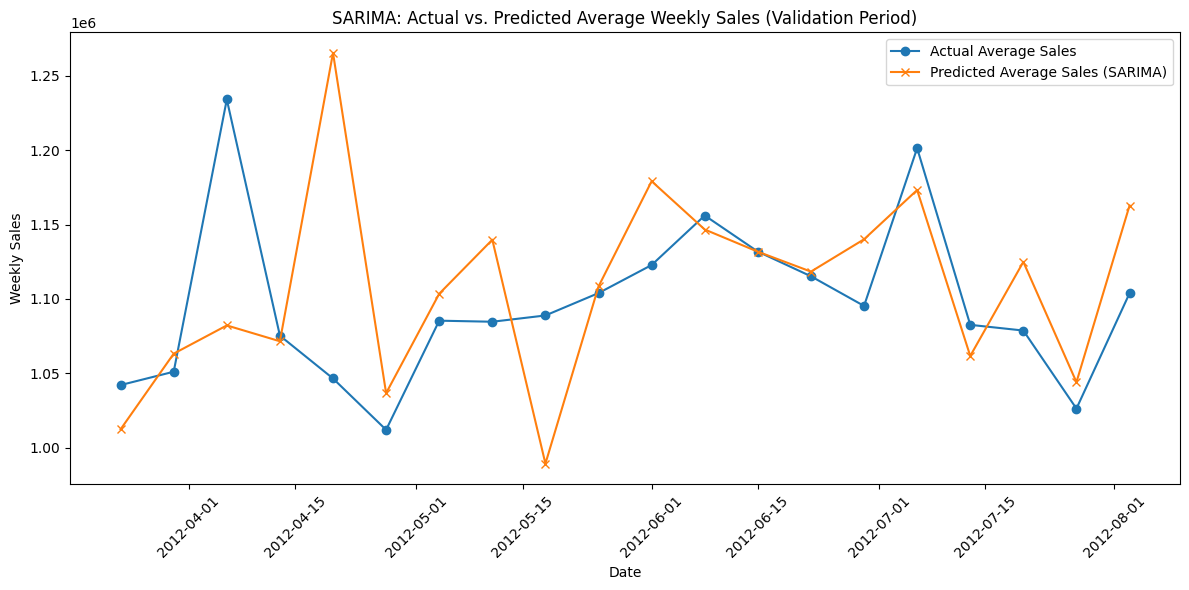

In [ ]:
# Aggregate predicted and actual sales by forecast date (across stores).
pred_by_date = defaultdict(list)
actual_by_date = defaultdict(list)

for store in random_stores:
    store_result = results_dict['SARIMA']['store_results'][store]
    for dt, pred, act in zip(store_result['forecast_dates'],
                             store_result['predictions'],
                             store_result['actuals']):
        dt = pd.to_datetime(dt)
        pred_by_date[dt].append(pred)
        actual_by_date[dt].append(act)

# Sort forecast dates
sorted_dates = sorted(pred_by_date.keys())

# Compute the average prediction and actual value for each date
avg_pred = [np.mean(pred_by_date[dt]) for dt in sorted_dates]
avg_actual = [np.mean(actual_by_date[dt]) for dt in sorted_dates]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, avg_actual, marker='o', label='Actual Average Sales')
plt.plot(sorted_dates, avg_pred, marker='x', label='Predicted Average Sales (SARIMA)')
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("SARIMA: Actual vs. Predicted Average Weekly Sales (Validation Period)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### XGBoost

#### Separate train test split and growing windows

In [ ]:
# Split the 131 weeks: the first 105 weeks for training and the next 26 weeks for validation
train_dates = train_val_dates[:105]
val_dates = train_val_dates[105:]

# We will forecast in 4-week horizons over the 20 validation weeks.
forecast_horizon = 1
n_forecast_iterations = len(val_dates) // forecast_horizon  # should be 20/2 = 10

# random_stores = random.sample(stores, 25)


#### Training

In [ ]:
def create_features(df, lags=[1, 2], include_diffs=True):
    df = df.copy()
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["holiday_flag_int"] = df["holiday_flag"].astype(int)
    
    # Create lag features
    for lag in lags:
        df[f"sales_lag_{lag}"] = df["weekly_sales"].shift(periods = lag)
    
    # Create difference features if required.
    if include_diffs:
        # First-order difference: difference between consecutive weekly_sales
        df["sales_diff_1"] = df["weekly_sales"].diff(1)
        # Second-order difference: difference of first differences (or equivalently
        # the two-period difference)
        df["sales_diff_2"] = df["weekly_sales"].diff(2)
    
    # Drop rows with missing values due to lag / difference calculation.
    df = df.dropna()
    return df

In [ ]:
results_dict["XGBoost"] = {"store_results": {}, "aggregated_metrics": {}}

# Assume stores are available from the categorical 'store' column.
stores = df["store"].cat.categories.tolist()

# Define lag values. (These are used in addition to our newly added difference features.)
lag_features = [1, 2, 3, 4, 5, 6]

for store in stores:
    # Filter and sort the data for the current store.
    store_df = df[df["store"] == store].sort_values("date").reset_index(drop=True)

    # Split the store's data into training (105 weeks) and validation (26 weeks).
    train_store_df = store_df[store_df["date"].isin(train_dates)]
    valid_store_df = store_df[store_df["date"].isin(val_dates)]
    
    # Start the growing window with the training data.
    data_gw = train_store_df.copy()
    data_gw = data_gw.sort_values("date").reset_index(drop=True)
    
    # Lists to hold forecasts/actuals for the current store.
    store_predictions = []
    store_actuals = []
    forecast_dates_list = []
    
    # Calculate the number of iterations based on the forecast horizon.
    n_iter = len(val_dates) // forecast_horizon
    
    for i in range(n_iter):
        # --- TRAINING STEP ---
        # Build the training features using the helper function (includes diffs).
        train_feats = create_features(data_gw, lags=lag_features, include_diffs=True)
        
        # Define the feature set.
        # Calendar features, holiday_flag, CPI, lags, and differences.
        X_train = train_feats[[
            "month",
            "year",
            "holiday_flag_int",
            "cpi",
            "sales_lag_1",
            "sales_lag_2",
            "sales_lag_3",
            "sales_lag_4",
            "sales_lag_5",
            "sales_lag_6",
            "sales_diff_1",
            "sales_diff_2"
        ]]
        y_train = train_feats["weekly_sales"]
        
        # Train the XGBoost model. Adjust hyperparameters as needed.
        model = xgb.XGBRegressor(
            objective="reg:squarederror",
            n_estimators=50,
            max_depth=5,
            learning_rate=0.075,
            random_state=42,
        )
        model.fit(X_train, y_train)
        
        # --- FORECASTING STEP ---
        # Determine forecast dates for the current window (next 2 weeks).
        fc_start = i * forecast_horizon
        fc_end = (i + 1) * forecast_horizon
        fc_dates = val_dates[fc_start:fc_end]
        
        fc_preds = []
        for fc_date in fc_dates:
            # Extract calendar and economic features from the validation set.
            row = valid_store_df[valid_store_df["date"] == fc_date]
            if row.empty:
                continue
            month = row["date"].dt.month.values[0]
            year = row["date"].dt.year.values[0]
            holiday_flag_int = int(row["holiday_flag"].values[0])
            CPI_val = row["cpi"].values[0]
            
            # --- Compute lag features from data_gw ---
            # Ensure we have enough observations to compute both lag and difference features.
            sales_lag_1 = data_gw["weekly_sales"].iloc[-1]
            sales_lag_2 = data_gw["weekly_sales"].iloc[-2] #if len(data_gw) >= 2 else sales_lag_1
            sales_lag_3 = data_gw["weekly_sales"].iloc[-3]
            sales_lag_4 = data_gw["weekly_sales"].iloc[-4] #if len(data_gw) >= 2 else sales_lag_1
            sales_lag_5 = data_gw["weekly_sales"].iloc[-3]
            sales_lag_6 = data_gw["weekly_sales"].iloc[-4] #if len(data_gw) >= 2 else sales_lag_1
            
            # Compute first difference feature
            sales_diff_1 = sales_lag_1 - sales_lag_2
            
            # For the second difference, we need the third most recent data point.
            if len(data_gw) >= 3:
                # sales_lag_3 = data_gw["weekly_sales"].iloc[-3]
                sales_diff_2 = sales_lag_1 - 2 * sales_lag_2 + sales_lag_3
            else:
                sales_diff_2 = sales_diff_1  # Fallback if not enough data
            
            # Construct a DataFrame for this forecast sample.
            X_fc = pd.DataFrame({
                "month": [month],
                "year": [year],
                "holiday_flag_int": [holiday_flag_int],
                "cpi": [CPI_val],
                "sales_lag_1": [sales_lag_1],
                "sales_lag_2": [sales_lag_2],
                "sales_lag_3": [sales_lag_3],
                "sales_lag_4": [sales_lag_4],
                "sales_lag_5": [sales_lag_5],
                "sales_lag_6": [sales_lag_6],
                "sales_diff_1": [sales_diff_1],
                "sales_diff_2": [sales_diff_2],
            })
            
            # Generate the prediction for the current forecast date.
            pred = model.predict(X_fc)[0]
            fc_preds.append(pred)
            
            # Append the predicted record to the growing window data.
            # Some features (e.g., temperature/fuel_price/unemployment) may not be available.
            new_row = pd.DataFrame({
                "store": [store],
                "date": [fc_date],
                "weekly_sales": [row["weekly_sales"].values[0]],
                "holiday_flag": [row["holiday_flag"].values[0]],
                "temperature": [np.nan],
                "fuel_price": [np.nan],
                "cpi": [CPI_val],
                "unemployment": [np.nan],
            })
            data_gw = pd.concat([data_gw, new_row], ignore_index=True)
            data_gw = data_gw.sort_values("date").reset_index(drop=True)
        
        # Get actual weekly_sales for these forecast dates.
        actual_vals = []
        for fc_date in fc_dates:
            act_row = valid_store_df[valid_store_df["date"] == fc_date]
            if act_row.empty:
                continue
            actual_vals.append(act_row["weekly_sales"].values[0])
        
        store_predictions.extend(fc_preds)
        store_actuals.extend(actual_vals)
        forecast_dates_list.extend(fc_dates)
    
    # Compute rmse for this store.
    store_rmse = rmse(np.array(store_actuals), np.array(store_predictions))
    
    # Save store results in the results dictionary.
    results_dict["XGBoost"]["store_results"][store] = {
        "forecast_dates": forecast_dates_list,
        "predictions": np.array(store_predictions),
        "actuals": np.array(store_actuals),
        "rmse": store_rmse,
    }


#### Calculate Errors

In [ ]:
all_rmse = []
for store in stores:
    all_rmse.append(results_dict["XGBoost"]["store_results"][store]["rmse"])
avg_rmse = np.mean(all_rmse)
std_rmse = np.std(all_rmse)

results_dict["XGBoost"]["aggregated_metrics"] = {
    "avg_rmse": avg_rmse,
    "std_rmse": std_rmse,
}

print("XGBoost Aggregated rmse across stores:")
print("Average rmse:", avg_rmse)
print("Standard Deviation of rmse:", std_rmse)

XGBoost Aggregated rmse across stores:
Average rmse: 93241.18785949251
Standard Deviation of rmse: 57405.855220578684


#### Visualize Predictions

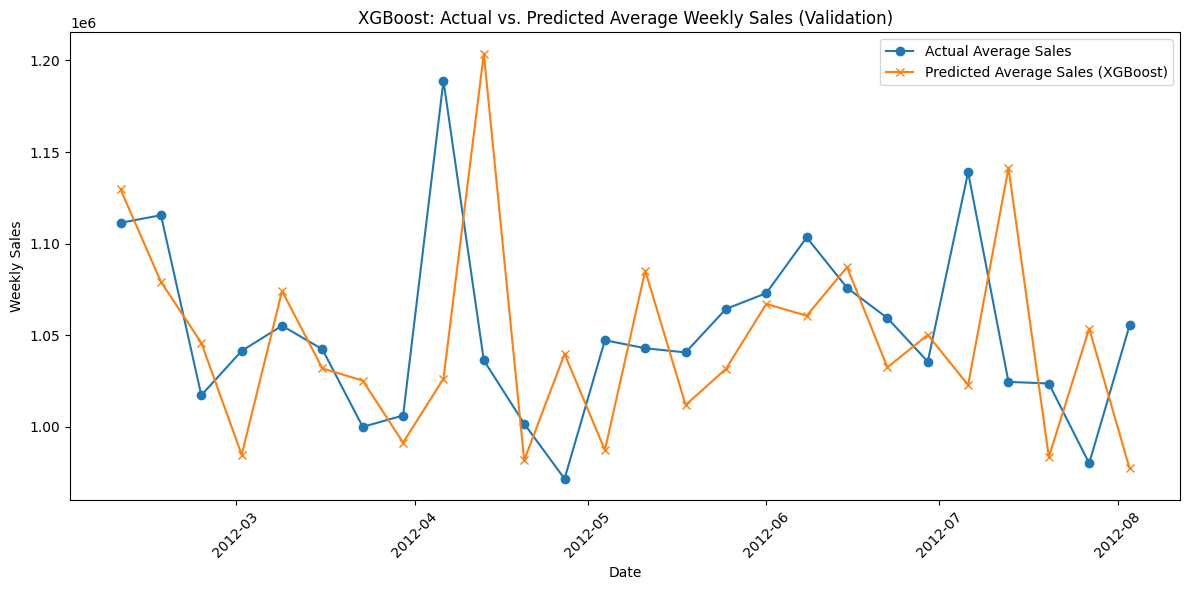

In [ ]:
pred_by_date = defaultdict(list)
actual_by_date = defaultdict(list)

for store in stores:
    store_result = results_dict["XGBoost"]["store_results"][store]
    for dt, pred, act in zip(store_result["forecast_dates"],
                             store_result["predictions"],
                             store_result["actuals"]):
        dt = pd.to_datetime(dt)
        pred_by_date[dt].append(pred)
        actual_by_date[dt].append(act)

# Sort the forecast dates and compute the average across stores.
sorted_dates = sorted(pred_by_date.keys())
avg_pred = [np.mean(pred_by_date[dt]) for dt in sorted_dates]
avg_actual = [np.mean(actual_by_date[dt]) for dt in sorted_dates]

plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, avg_actual, marker="o", label="Actual Average Sales")
plt.plot(sorted_dates, avg_pred, marker="x", label="Predicted Average Sales (XGBoost)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("XGBoost: Actual vs. Predicted Average Weekly Sales (Validation)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### FB Prophet

#### Separate train test split and growing windows

In [ ]:
# Split the 131 weeks: the first 105 weeks for training and the next 26 weeks for validation
train_dates = train_val_dates[:105]
val_dates = train_val_dates[105:]

# We will forecast in 4-week horizons over the 20 validation weeks.
forecast_horizon = 1
n_forecast_iterations = len(val_dates) // forecast_horizon  # should be 20/2 = 10

# random_stores = random.sample(stores, 25)


#### Training

In [ ]:
import logging

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

In [ ]:
# Initialize results dictionary for Prophet forecasts.
results_dict["Prophet"] = {"store_results": {}, "aggregated_metrics": {}}

# Get the list of stores (assuming the store column is categorical).
stores = df["store"].cat.categories.tolist()

holidays = (
    df[df['holiday_flag']][['date']]  # select only rows where holiday_flag is True
    .drop_duplicates()               # remove duplicate dates if needed
    .rename(columns={'date': 'ds'})
)
holidays['holiday'] = 'holiday'  # Label each date with a name (could be more specific)
# Optionally, if you believe the effect spans extra days, add a window:
holidays['lower_window'] = -1  # The holiday's effect starts one day prior
holidays['upper_window'] = 1   # The effect lasts one day after

# Loop over each store.
for store in stores:
    # --- Data Preparation for Prophet ---
    # Filter the data for the current store and sort by date.
    store_df = df[df["store"] == store].sort_values("date").reset_index(drop=True)
    
    # Split store_df into training and validation based on your date lists.
    train_store_df = store_df[store_df["date"].isin(train_dates)]
    valid_store_df = store_df[store_df["date"].isin(val_dates)]
    
    # Convert to Prophet's expected format: "ds" (for date) and "y" (for weekly_sales).
    train_prophet = train_store_df[["date", "weekly_sales"]].rename(
        columns={"date": "ds", "weekly_sales": "y"}
    )
    valid_prophet = valid_store_df[["date", "weekly_sales"]].rename(
        columns={"date": "ds", "weekly_sales": "y"}
    )
    
    # Initialize lists to store forecasts, actuals, and the forecast dates.
    store_predictions = []
    store_actuals = []
    forecast_dates_list = []
    
    # Determine the number of forecast iterations (e.g., for 26 weeks with a 2-week horizon).
    n_iter = len(valid_prophet) // forecast_horizon
    valid_dates = valid_prophet["ds"].tolist()  # these should already be sorted
    
    # Growing-window forecast loop.
    for i in range(n_iter):
        # Initialize the Prophet model with appropriate parameters
        model = Prophet(
            growth="linear",                # Use a linear trend.
            changepoints=None,              # Let Prophet automatically pick changepoints.
            n_changepoints=25,              # Default number of potential changepoints.
            changepoint_range=0.8,            # Use the first 80% of the history for changepoint detection.
            yearly_seasonality=True,        # Include yearly seasonality (important for holidays).
            weekly_seasonality=False,        # Include weekly seasonality (even for weekly data, if relevant).
            daily_seasonality=False,        # Daily seasonality is not applicable for weekly data.
            holidays=holidays,              # Pass in your holidays DataFrame.
            seasonality_mode="additive",    # Use an additive seasonality.
            seasonality_prior_scale=10.0,   # Default prior scale for seasonal effects.
            holidays_prior_scale=10.0,      # Default prior scale for holiday effects.
            changepoint_prior_scale=0.05,   # Controls the flexibility of trend changepoints.
            mcmc_samples=0,                 # Use MAP estimation for faster fitting.
            interval_width=0.80,            # 80% prediction intervals.
            uncertainty_samples=1000,       # Number of draws for uncertainty estimation.
            stan_backend=None,              # Automatically select a Stan backend.
            holidays_mode='additive'        # Use additive holiday effects.
        )
        model.fit(train_prophet)
        
        # Determine the current forecast dates from the validation set.
        fc_start = i * forecast_horizon
        fc_end = (i + 1) * forecast_horizon
        fc_dates = valid_dates[fc_start:fc_end]
        
        # Create a "future" dataframe with the forecast dates.
        future = pd.DataFrame({"ds": fc_dates})
        forecast = model.predict(future)
        predictions = forecast["yhat"].values
        
        # Retrieve the actual observed sales for these fc_dates.
        actual_vals = valid_prophet[valid_prophet["ds"].isin(fc_dates)]["y"].values
        
        # Store predictions, actuals, and the associated dates.
        store_predictions.extend(predictions)
        store_actuals.extend(actual_vals)
        forecast_dates_list.extend(fc_dates)
        
        # IMPORTANT: Grow the training set with the ACTUAL observed values from the validation set.
        new_train = valid_prophet[valid_prophet["ds"].isin(fc_dates)]
        train_prophet = pd.concat([train_prophet, new_train]).sort_values("ds").reset_index(drop=True)
    
    # Compute the RMSE for the current store.
    store_rmse = rmse(np.array(store_actuals), np.array(store_predictions))

    print(f"Store: {store}, RMSE: {store_rmse}")
    
    # Save the store-specific results.
    results_dict["Prophet"]["store_results"][store] = {
        "forecast_dates": forecast_dates_list,
        "predictions": np.array(store_predictions),
        "actuals": np.array(store_actuals),
        "rmse": store_rmse,
    }


Store: 1, RMSE: 109453.42087280302
Store: 10, RMSE: 90310.93169744058
Store: 11, RMSE: 78822.75367009503
Store: 12, RMSE: 48109.74824184992
Store: 13, RMSE: 93681.86438999111
Store: 14, RMSE: 196933.9059604053
Store: 15, RMSE: 36736.79404710509
Store: 16, RMSE: 32100.561207943556
Store: 17, RMSE: 48932.74199100521
Store: 18, RMSE: 73699.67742298725
Store: 19, RMSE: 84821.4213153649
Store: 2, RMSE: 118138.26424885621
Store: 20, RMSE: 159783.04928618894
Store: 21, RMSE: 38921.85839887736
Store: 22, RMSE: 56143.175198336394
Store: 23, RMSE: 78979.16804099131
Store: 24, RMSE: 84545.73789684301
Store: 25, RMSE: 37523.7930658413
Store: 26, RMSE: 59702.48404277817
Store: 27, RMSE: 86838.58140146261
Store: 28, RMSE: 146042.75341677928
Store: 29, RMSE: 30753.605879096373
Store: 3, RMSE: 29656.571021971275
Store: 30, RMSE: 16883.238708798843
Store: 31, RMSE: 60225.02804044986
Store: 32, RMSE: 49133.59236091076
Store: 33, RMSE: 19541.02019571724
Store: 34, RMSE: 43898.188363125555
Store: 35, RMSE

#### Calculate Errors

In [ ]:
all_rmse = [results_dict["Prophet"]["store_results"][store]["rmse"] for store in stores]
avg_rmse = np.mean(all_rmse)
std_rmse = np.std(all_rmse)

results_dict["Prophet"]["aggregated_metrics"] = {"avg_rmse": avg_rmse, "std_rmse": std_rmse}

print("Prophet Aggregated RMSE across stores:")
print("Average RMSE:", avg_rmse)
print("Standard Deviation of RMSE:", std_rmse)

Prophet Aggregated RMSE across stores:
Average RMSE: 62552.29671520855
Standard Deviation of RMSE: 39133.22418015517


#### Visualize Predictions

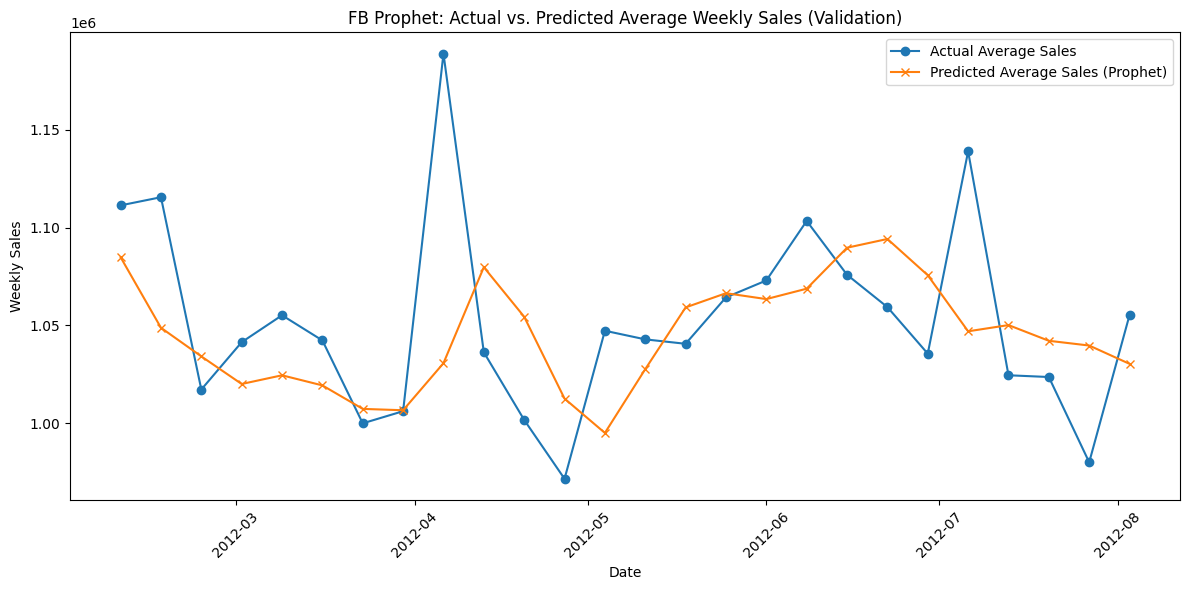

In [ ]:
# Aggregate predicted and actual values by forecast date across all stores.
pred_by_date = defaultdict(list)
actual_by_date = defaultdict(list)

for store in stores:
    store_result = results_dict["Prophet"]["store_results"][store]
    for dt, pred, act in zip(store_result["forecast_dates"], 
                             store_result["predictions"], 
                             store_result["actuals"]):
        # Make sure that the forecast date is a pd.Timestamp.
        dt = pd.to_datetime(dt)
        pred_by_date[dt].append(pred)
        actual_by_date[dt].append(act)

# Sort forecast dates.
sorted_dates = sorted(pred_by_date.keys())

# Compute the average prediction and actual sales for each date.
avg_pred = [np.mean(pred_by_date[dt]) for dt in sorted_dates]
avg_actual = [np.mean(actual_by_date[dt]) for dt in sorted_dates]

plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, avg_actual, marker="o", label="Actual Average Sales")
plt.plot(sorted_dates, avg_pred, marker="x", label="Predicted Average Sales (Prophet)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("FB Prophet: Actual vs. Predicted Average Weekly Sales (Validation)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()